In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from scipy import interpolate
import math
from scipy.integrate import quad
import Options
from matplotlib import pyplot as plt
import datetime
import time
import tushare
%matplotlib inline
plt.style.use('ggplot')

In [10]:
token = '37f756066bdfd9e6973cc51e088dddd1f3576f970fe77da55592be27'
tushare.set_token(token)
pro = tushare.pro_api(token)

trading_days = pro.query('trade_cal',
                         exchange='SSE',
                         start_date='20150101',
                         end_date='20220101')
num_tds = trading_days.iloc[np.where(trading_days['is_open'])].cal_date.values
trading_days = pd.to_datetime(trading_days.iloc[np.where(
    trading_days['is_open'])].cal_date).astype(str).reset_index(
        drop=True).values
trading_days=trading_days[::-1]

array(['2021-12-31', '2021-12-30', '2021-12-29', ..., '2015-01-07',
       '2015-01-06', '2015-01-05'], dtype=object)

In [11]:
all_info = pd.read_csv("cleaned_data_50ETF_option.csv", low_memory=False)
shibor_info = pd.read_csv("combined_SHIBOR.csv")
index_info = pd.read_csv('data_50ETF_index.csv')
index_info = index_info[index_info.date >= all_info.date[0]].reset_index(
    drop=True)

In [52]:
pd.to_datetime(trading_dates).values[0]

numpy.datetime64('2015-02-09T00:00:00.000000000')

In [12]:
shibor_dates = np.array([1., 5., 10., 21., 63., 126., 189., 252.])
info_dict = {'date': [], 'exe_date': [], 'implied_vol': []}
trading_dates = pd.to_datetime(trading_dates)
indexes = index_info.close.values


def abs_diff(x):
    s = x.values[0]
    for k in range(1, len(x)):
        s -= x.values[k]
    return np.abs(s)


implied_index = []
case1, case2 = [], []
all_dict = {day: [] for day in trading_dates}
all_tuples = []
ptm_df = pd.DataFrame({'dtm': [], 'call_imp': [], 'put_imp': []})
for td in tqdm(trading_dates):

    td_index = np.where(trading_days == td)[0][0]
    td_shibor = shibor_info[shibor_info.date == td].iloc[0].values[1:]

    shibor_helper = interpolate.interp1d(shibor_dates,
                                         td_shibor,
                                         kind='slinear')

    td_info = all_info[all_info.date == td]

    td_mats = np.sort(td_info.exe_enddate.unique())

    td_shibor = shibor_info[shibor_info.date == td].values[0][1:]

    td_shibor = td_shibor[-1] / 100

    #     td_shibor = 0.02

    temp_imp = []
    for maturity in td_mats:

        mt_index = np.where(trading_days == maturity)[0][0]

        ptmday = mt_index - td_index + 1

        mat_info = td_info[td_info.exe_enddate == maturity]
        available_prices = mat_info.exe_price.sort_values().unique()
        atm = mat_info.groupby("exe_price").apply(
            lambda x: abs_diff(x['close'])).idxmin()
        call = mat_info[(mat_info.exe_price == atm)
                        & (mat_info.exe_mode == 'call')]
        put = mat_info[(mat_info.exe_price == atm)
                       & (mat_info.exe_mode == 'put')]

        discount = np.exp(-td_shibor * ptmday / 252)
        implied_underlying = call.close.values[0] - put.close.values[
            0] + atm * discount
        temp_imp.append(implied_underlying)
        option = Options.Strategy()
        option.getData(atm, td_shibor, ptmday / 252, 0.2)
        implied_vol = option.EuroCallIV(implied_underlying,
                                        call.close.values[0])
        implied_vol_p = option.EuroPutIV(implied_underlying,
                                         put.close.values[0])

        all_tuples.append(
            (eval(''.join(td.split('-'))), eval(''.join(maturity.split('-'))),
             ptmday, implied_vol, implied_vol_p))
        tmp = pd.DataFrame({
            'dtm': [ptmday],
            'call_imp': [implied_vol],
            'put_imp': [implied_vol_p],
            'date': [td]
        })
        ptm_df = pd.concat([ptm_df, tmp])
    implied_index.append(np.mean(temp_imp))

100%|██████████████████████████████████████████████████████████████████████████████| 1504/1504 [01:09<00:00, 21.68it/s]


In [15]:
ptm_df=ptm_df.reset_index(drop=True)

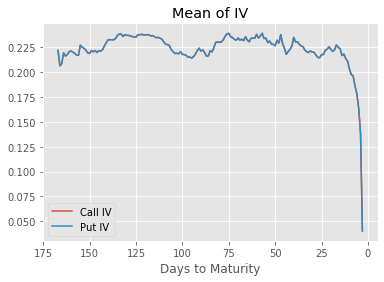

In [32]:
wa = ptm_df.groupby(ptm_df.dtm).mean().reset_index(drop=True)
xa = np.array(range(len(wa), 0, -1))
xa = xa[:-2]
wa = wa[:-2]
plt.plot(xa, wa.call_imp.values[::-1])
plt.plot(xa, wa.put_imp.values[::-1])
plt.gca().invert_xaxis()
plt.xlabel("Days to Maturity")
plt.legend(["Call IV", "Put IV"])
plt.title("Mean of IV")
plt.show()

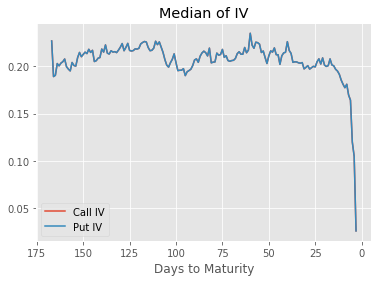

In [33]:
wa = ptm_df.groupby(ptm_df.dtm).median().reset_index(drop=True)
xa = np.array(range(len(wa), 0, -1))
xa = xa[:-2]
wa = wa[:-2]
plt.plot(xa, wa.call_imp.values[::-1])
plt.plot(xa, wa.put_imp.values[::-1])
plt.gca().invert_xaxis()
plt.xlabel("Days to Maturity")
plt.legend(["Call IV", "Put IV"])
plt.title("Median of IV")
plt.show()

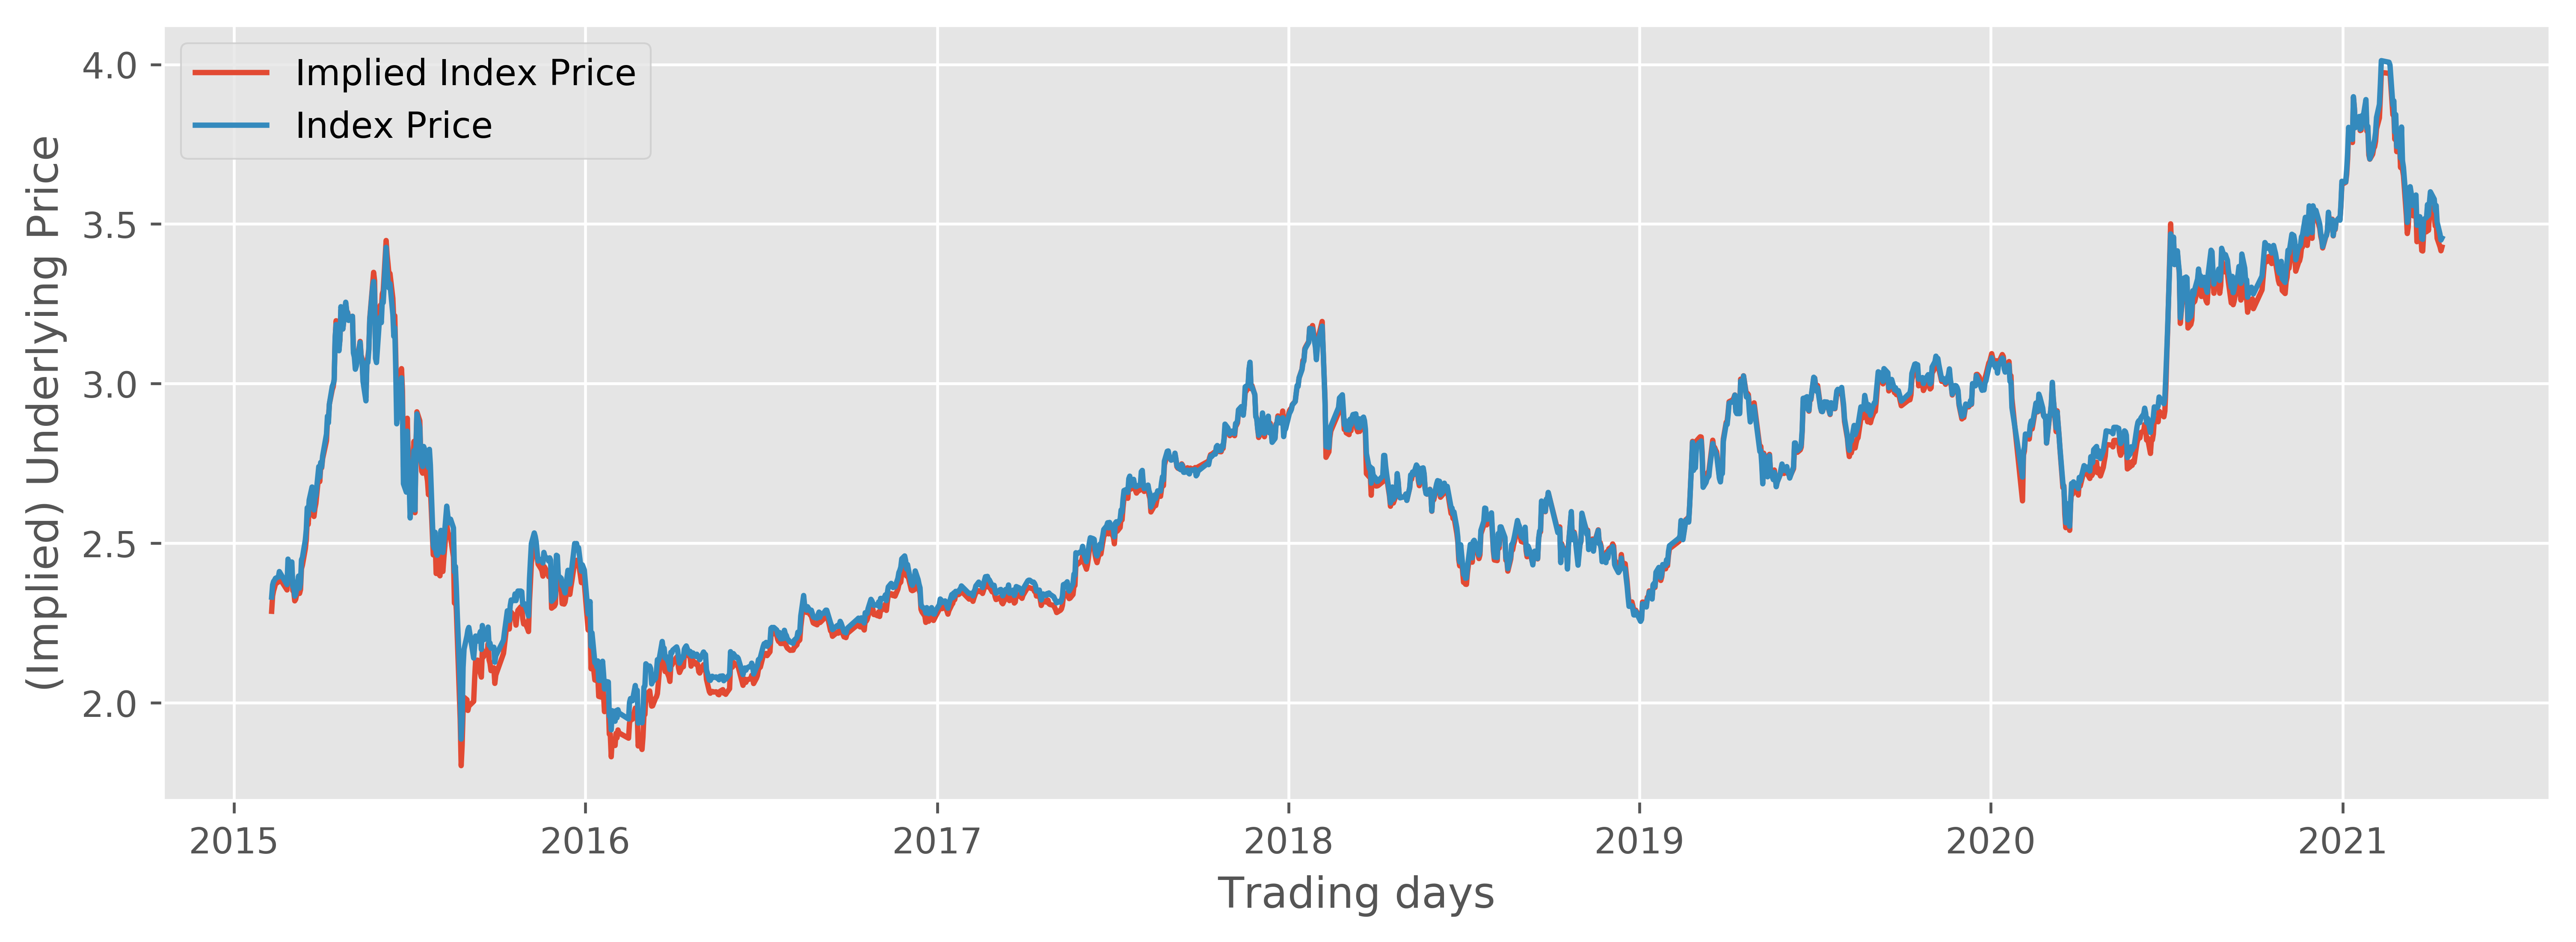

In [47]:
dates = pd.to_datetime(ptm_df.date.sort_values()).unique()

plt.figure(figsize=(12, 4), dpi=600)
plt.style.use('ggplot')

plt.xlabel('Trading days')
plt.ylabel('(Implied) Underlying Price')

plt.plot(dates, implied_index)
plt.plot(dates, indexes)

plt.legend(['Implied Index Price', 'Index Price'])

plt.show()

In [48]:
call_dir = 'td_vol//call//'
put_dir = 'td_vol//put//'
lengths = []
maturity = all_info.exe_enddate.apply(
    lambda x: eval(''.join(x.split('-')))).unique()
for k in sorted(maturity):
    selected = np.array([[tup[0], tup[-2], tup[-1], tup[2]]
                         for tup in all_tuples if tup[1] == k])
    dates, imp_vol, ivp, dtm = selected[:, 0].astype(
        int), selected[:, 1], selected[:, 2], selected[:, 3]
    lengths.append(dates.shape[0])
    cfn = call_dir + 'implied_volatility_{}.csv'.format(k)
    pfn = put_dir + 'implied_volatility_{}.csv'.format(k)
    cv = pd.DataFrame({'date': dates, 'imp_vol': imp_vol, 'to_maturity': dtm})
    pv = pd.DataFrame({'date': dates, 'imp_vol': ivp, 'to_maturity': dtm})
    cv['imp_change'] = cv['imp_vol'].pct_change()
    pv['imp_change'] = pv["imp_vol"].pct_change()
    cv['week_day'] = cv.date.apply(lambda x: datetime.datetime.fromtimestamp(
        time.mktime(time.strptime(str(x), "%Y%m%d"))).weekday())
    pv['week_day'] = pv.date.apply(lambda x: datetime.datetime.fromtimestamp(
        time.mktime(time.strptime(str(x), "%Y%m%d"))).weekday())
    cv.to_csv(cfn, index=False)
    pv.to_csv(pfn, index=False)